# Analisando os dados dos sites da globo usando bag of words

In [64]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_csv('C:\\Users\\samsung\\Desktop\\df_sites_globo2.csv')

In [65]:
df.head()

,Unnamed: 0,url,titulo,conteudo
0,0,https://g1.globo.com/globonews/globonews-docum...,"""fevereiros"" revela as origens de maria bethân...","O documentário, parceria entre GloboNews e Glo..."
1,0,https://g1.globo.com/globonews/jornal-globonew...,george w. bush parabeniza biden e harris pela ...,"O ex-presidente americano, o republicano Georg..."
2,0,https://g1.globo.com/globonews/fatos-e-versoes...,taxação do aço brasileiro pelos eua causa surp...,A recente taxação do aço brasileiro por parte ...
3,0,https://g1.globo.com/globonews/globonews-docum...,'documentário 24h em wuhan' mostra a realidade...,Equipe de uma TV chinesa percorreu o local e m...
4,0,https://g1.globo.com/globonews/jornal-das-dez/...,guga chacra comenta discurso de joe biden ‘um ...,"Democrata Joe Biden discursou em Wilmington, n..."


In [66]:
print(df.titulo.isnull().sum(),df.url.isnull().sum())

0 0


In [67]:
df.shape

(1500, 4)

In [68]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,url,titulo,conteudo
0,https://g1.globo.com/globonews/globonews-docum...,"""fevereiros"" revela as origens de maria bethân...","O documentário, parceria entre GloboNews e Glo..."
1,https://g1.globo.com/globonews/jornal-globonew...,george w. bush parabeniza biden e harris pela ...,"O ex-presidente americano, o republicano Georg..."
2,https://g1.globo.com/globonews/fatos-e-versoes...,taxação do aço brasileiro pelos eua causa surp...,A recente taxação do aço brasileiro por parte ...
3,https://g1.globo.com/globonews/globonews-docum...,'documentário 24h em wuhan' mostra a realidade...,Equipe de uma TV chinesa percorreu o local e m...
4,https://g1.globo.com/globonews/jornal-das-dez/...,guga chacra comenta discurso de joe biden ‘um ...,"Democrata Joe Biden discursou em Wilmington, n..."


In [69]:
import numpy as np

conditions = [
    (df['url'].str.contains('gshow')),
    (df['url'].str.contains('globonews')),
    (df['url'].str.contains('globoesporte')),
    ]

choices = ['gshow', 'globonews','globoesporte']

df['url_origem'] = np.select(conditions,choices)

df.head()

,url,titulo,conteudo,url_origem
0,https://g1.globo.com/globonews/globonews-docum...,"""fevereiros"" revela as origens de maria bethân...","O documentário, parceria entre GloboNews e Glo...",globonews
1,https://g1.globo.com/globonews/jornal-globonew...,george w. bush parabeniza biden e harris pela ...,"O ex-presidente americano, o republicano Georg...",globonews
2,https://g1.globo.com/globonews/fatos-e-versoes...,taxação do aço brasileiro pelos eua causa surp...,A recente taxação do aço brasileiro por parte ...,globonews
3,https://g1.globo.com/globonews/globonews-docum...,'documentário 24h em wuhan' mostra a realidade...,Equipe de uma TV chinesa percorreu o local e m...,globonews
4,https://g1.globo.com/globonews/jornal-das-dez/...,guga chacra comenta discurso de joe biden ‘um ...,"Democrata Joe Biden discursou em Wilmington, n...",globonews


In [70]:
df.describe()

,url,titulo,conteudo,url_origem
count,1500,1500,1500,1500
unique,1500,1468,1465,3
top,https://g1.globo.com/globonews/em-foco-com-and...,participante do 'milionário' pede duas ajudas ...,Edivan Duarte participa do 'Quem Quer Ser Um ...,gshow
freq,1,5,5,500


# Pré-processamento nos textos das tags P

* Como os dados estão balanceados, vamos usar a acurácia como métrica, e nossa baseline será de 33% (dado que são 3 categorias)

* Primeiro, vamos analisar os dados sem qualquer pré-processamento

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def log_fit(max_features = 50,coluna = 'conteudo'):
    
    vetorizador = CountVectorizer(max_features = max_features)

    bag_of_words = vetorizador.fit_transform(df[coluna])


    x_train, x_test, y_train, y_test = train_test_split(bag_of_words, df.url_origem, test_size=0.33, random_state=42)

    reg_log = LogisticRegression()

    reg_log.fit(x_train,y_train)
    print(reg_log.score(x_test,y_test))
    
log_fit()

0.9454545454545454


* Os dados estão muito acima da baseline e é muito improváel que apenas uma palavra possa definir se um texto é de esporte, notícias ou entretenimento

In [72]:
log_fit(1)
log_fit(3)
log_fit(5)
log_fit(10)

0.5515151515151515
0.6323232323232323
0.7272727272727273
0.8404040404040404


## Removendo as palavras que enviesam o modelo

In [73]:
# Grafico mostrando as 10 palavras mais usadas

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize

# primeiro vamos usar o tokenizador mais simples
tokenizador_espaco = tokenize.WhitespaceTokenizer()

In [74]:
def pareto(coluna_texto,tokenizador,url_origem = 'all',num_bar = 10):
    
    if str(url_origem) == 'all':
        cor = 'grey'
    elif str(url_origem) == 'globoesporte':
        cor = 'green'
    elif str(url_origem) == 'globonews':
        cor = 'red'
    else:
        cor  = 'orange'
    
    if str(url_origem) != 'all':
        df_n = df[df['url_origem'] == url_origem]
    else:
        df_n = df
    
    palavras = ' '.join([texto for texto in df_n[coluna_texto]])
    frequencia = nltk.FreqDist(tokenizador.tokenize(palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = num_bar)
    plt.figure(figsize=(20,8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = cor)
    ax.set(ylabel = "Contagem")
    plt.show()

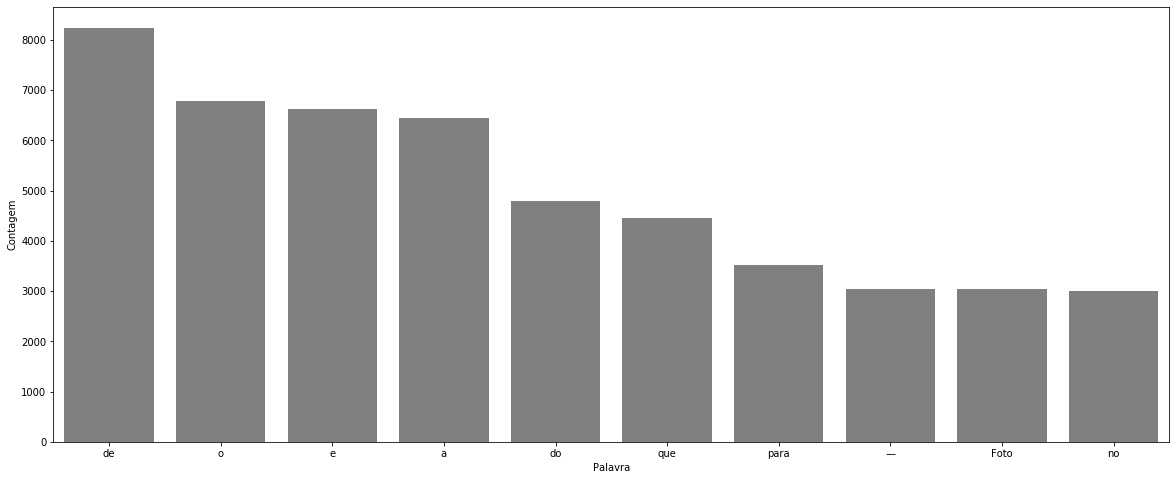

In [75]:
pareto('conteudo',tokenizador_espaco)

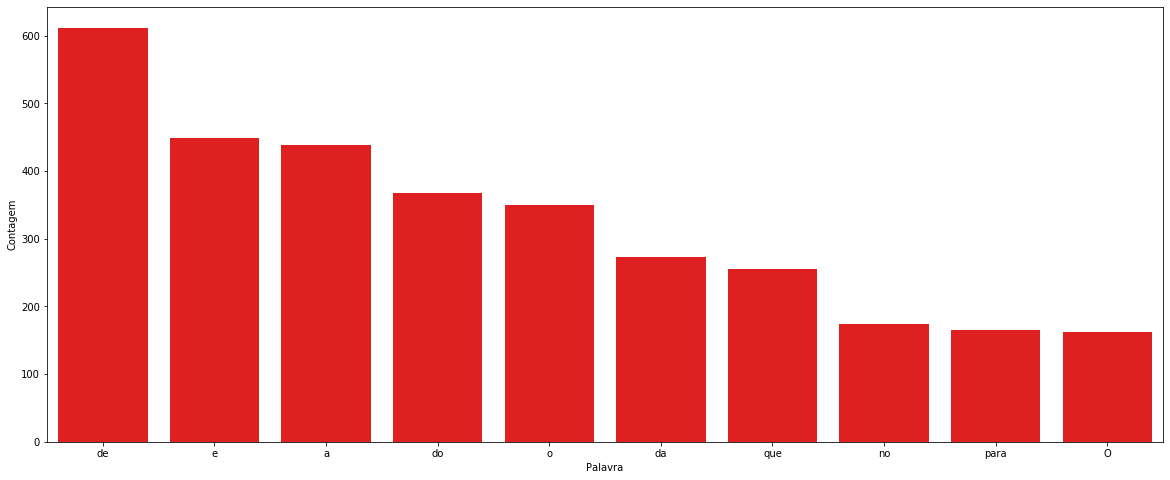

In [76]:
pareto('conteudo',tokenizador_espaco,'globonews')

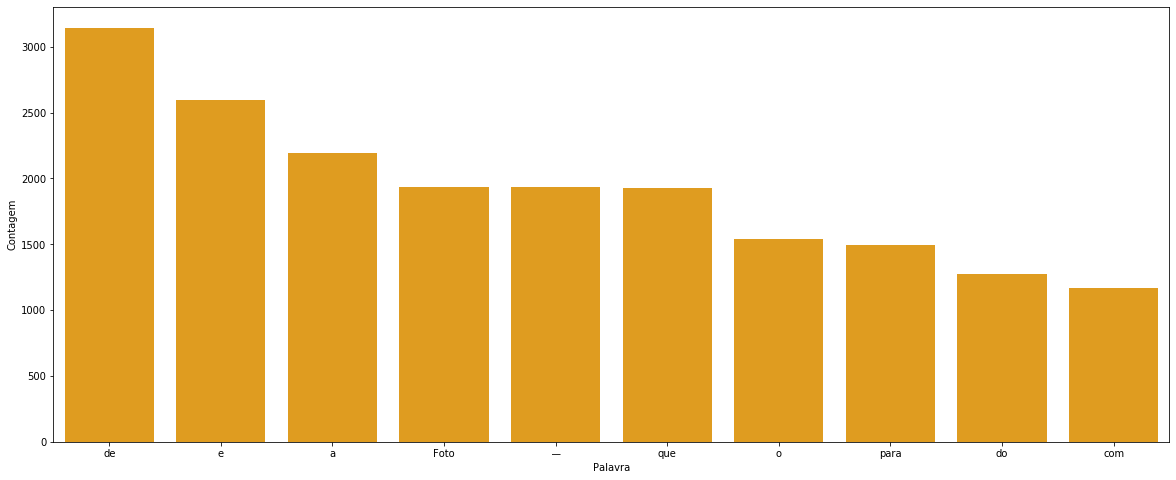

In [77]:
pareto('conteudo',tokenizador_espaco,'gshow')

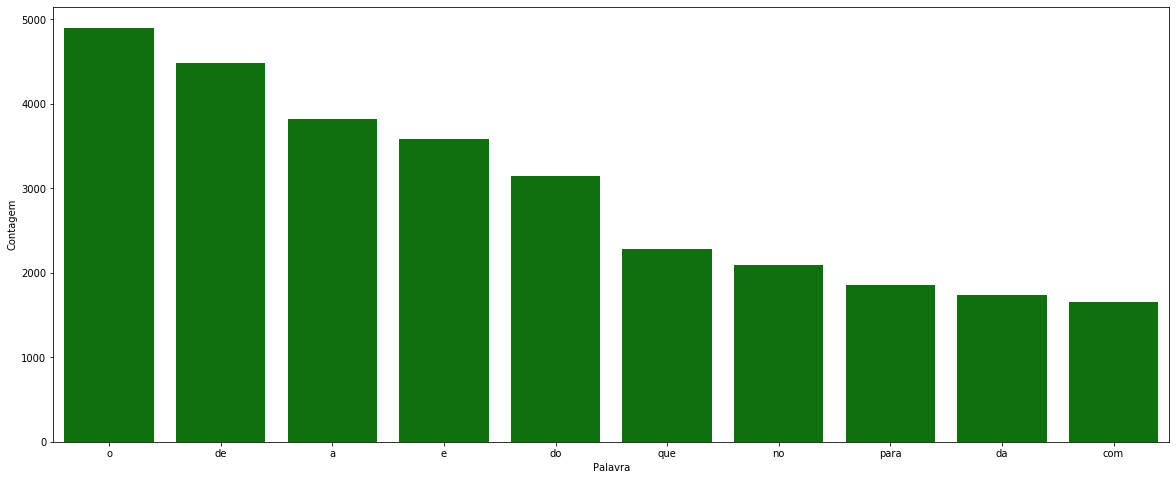

In [78]:
pareto('conteudo',tokenizador_espaco,'globoesporte')

### Processamentos básicos no texto

1. Remoção de stopwords
2. Transformar tudo em minúsculo
3. remover pontuações
4. remover acentuações

In [79]:
def show_palavras_mais_usadas():
    
    palavras = ' '.join([texto for texto in df['texto_processado']])
    frequencia = nltk.FreqDist(tokenizador_ponto.tokenize(palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = 50)
    print(df_frequencia)

In [80]:
# lib pra remover acentos
import unidecode

# cria lista de stop words
stop_words = nltk.corpus.stopwords.words("portuguese")
stop_words = [unidecode.unidecode(palavra) for palavra in stop_words]

# remove pontuações
from string import punctuation
pontuações = []
for ponto in punctuation:
    pontuações.append(ponto)
    
# Separa usando os pontos    
tokenizador_ponto = tokenize.WordPunctTokenizer()

# fui removendo conforme elas apareciam na lista de palavras mais usadas
dicionário = ['—','),','texto','foto','video','reproducao','reproducaoinstagram',
             'globo','globonews','globoesporte','-','--','",','videos','gshow','tv'
             ,').','images']

filtro = pontuações + stop_words + dicionário

texto_processado = []
for texto_pagina in df.conteudo:
    palavras_relevantes = []
    texto_pagina_tokenizado = tokenizador.tokenize(texto_pagina)
    for palavra in texto_pagina_tokenizado:
        palavra = palavra.lower()
        palavra = unidecode.unidecode(palavra)
        if palavra not in filtro:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['texto_processado'] = texto_processado

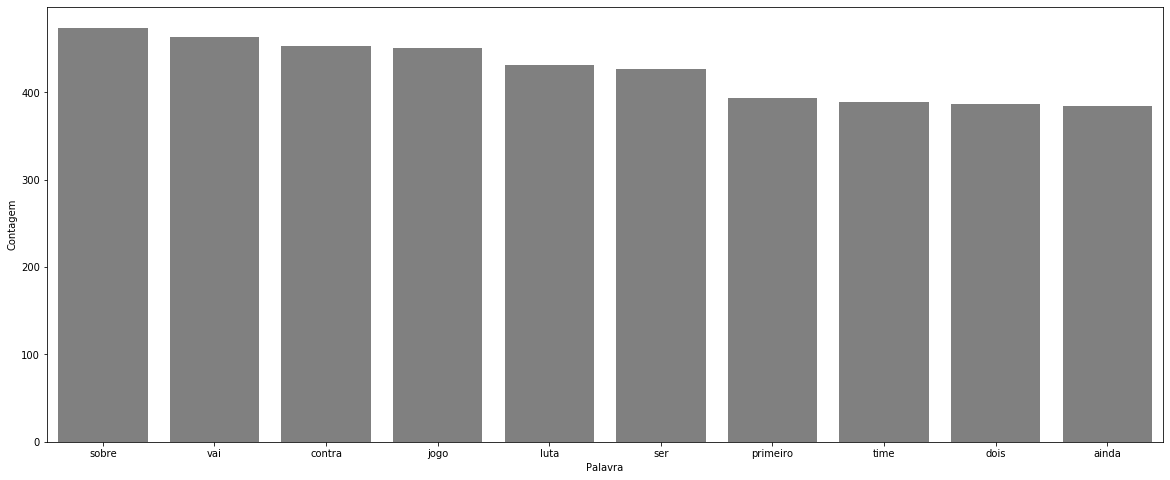

In [81]:
pareto('texto_processado',tokenizador_ponto)

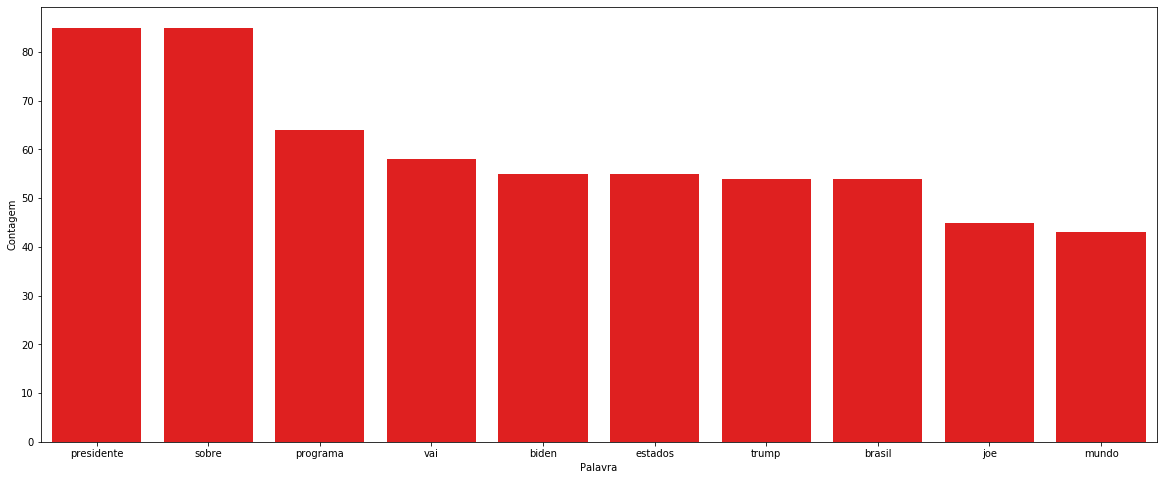

In [82]:
pareto('texto_processado',tokenizador_ponto,'globonews')

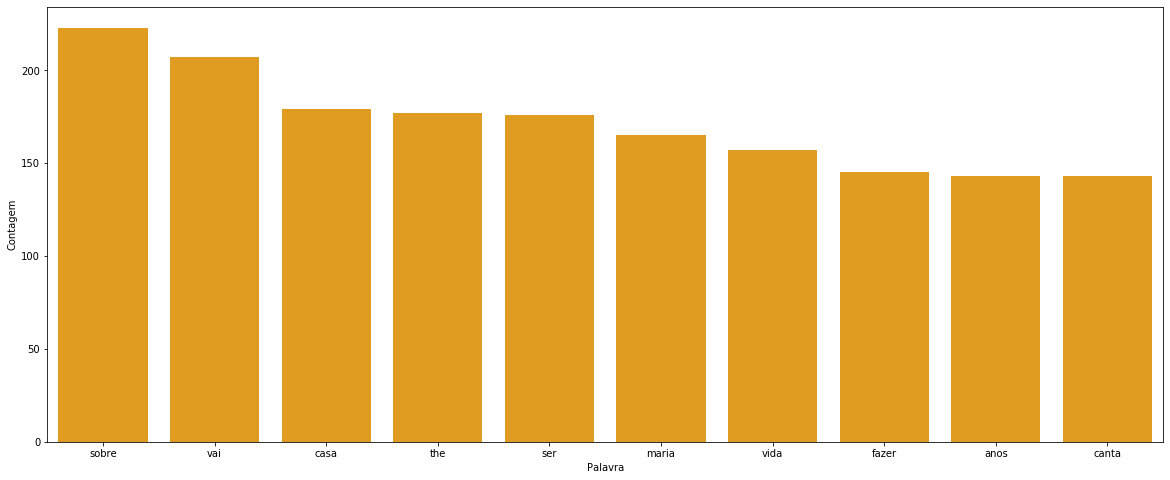

In [83]:
pareto('texto_processado',tokenizador_ponto,'gshow')

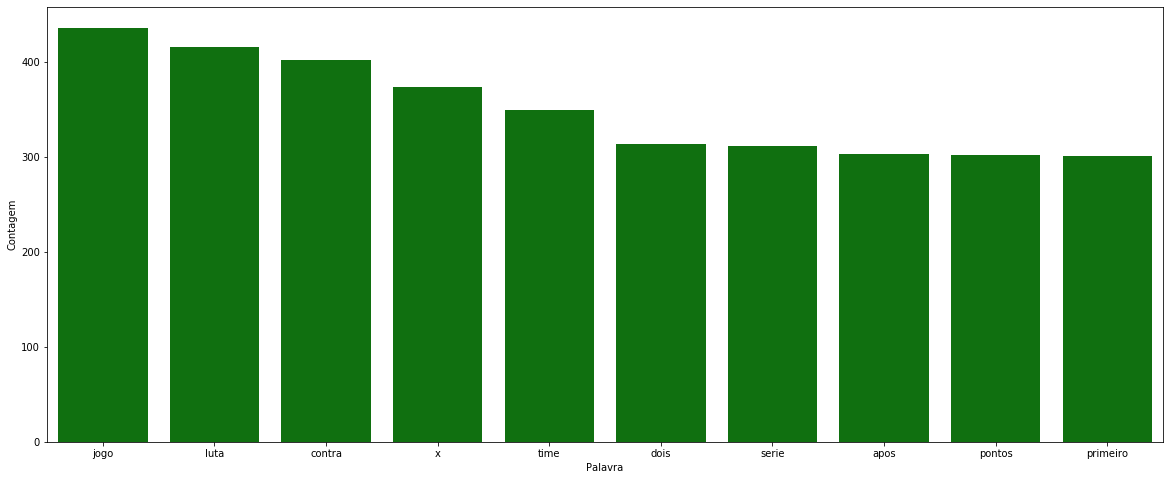

In [84]:
pareto('texto_processado',tokenizador_ponto,'globoesporte')

In [85]:
log_fit(coluna = 'texto_processado')

0.7777777777777778


In [86]:
show_palavras_mais_usadas()

         Palavra  Frequência
210        sobre         474
87           vai         463
745       contra         453
1819        jogo         451
103         luta         431
187          ser         427
215     primeiro         393
1345        time         389
121         dois         387
53         ainda         384
3183           x         376
217         apos         360
276        serie         353
410          dia         353
635         casa         343
289         anos         338
128       brasil         326
59    brasileiro         323
67        equipe         323
34       vitoria         316
604        gente         309
1777      pontos         306
266          ter         304
151        fazer         293
7288         ufc         291
2299       final         289
5556       round         286
232      segundo         283
160            1         264
530        paulo         257
961        jogos         256
852        tempo         253
1487         bem         252
4008      roda

In [87]:
df.to_csv('C:\\Users\\samsung\\Desktop\\df_sites_globo2_stopwords.csv',index = False)